In [1]:
# implementing STA/LTA implementation from scratch
# author: Kaushik Pradhan (kpradhan@miners.utep.edu)
# last updated: 05/10/2024

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import pandas as pd
from obspy.signal.trigger import recursive_sta_lta, trigger_onset

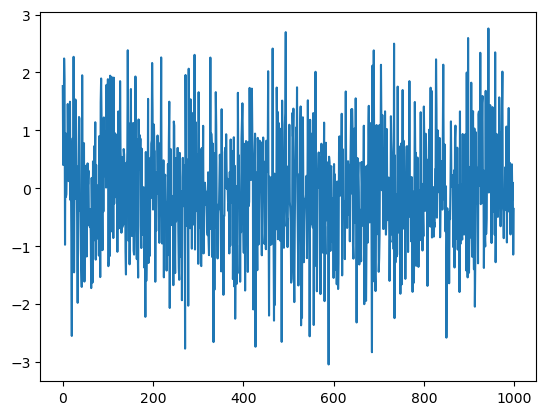

In [3]:
# Generate a random time series
np.random.seed(0)
time_series = np.random.randn(1000)

plt.figure()
plt.plot(time_series)
plt.show()

In [4]:
# Define STA/LTA function
def sta_lta(signal, short_window, long_window, threshold):
    sta = np.convolve(signal, np.ones(short_window), 'valid') / short_window
    lta = np.convolve(signal, np.ones(long_window), 'valid') / long_window
    # Ensure sta and lta are the same length
    sta = sta[:len(lta)]
    ratio = sta / lta

    # Detect when STA/LTA ratio exceeds the threshold
    events = np.where(ratio > threshold)[0] + long_window
    return events, ratio

In [5]:
# Parameters
short_window = 50
long_window = 200
threshold = 2.0

# Apply STA/LTA algorithm
events, ratio = sta_lta(time_series, short_window, long_window, threshold)

In [6]:
events

array([ 231,  232,  233,  235,  238,  239,  240,  241,  244,  245,  246,
        251,  259,  260,  261,  262,  263,  264,  265,  266,  267,  268,
        269,  270,  271,  272,  273,  274,  275,  276,  277,  278,  279,
        280,  281,  282,  283,  284,  285,  286,  287,  288,  289,  290,
        291,  292,  293,  294,  295,  296,  297,  298,  299,  300,  302,
        303,  304,  305,  306,  307,  419,  420,  421,  422,  423,  424,
        425,  426,  427,  428,  429,  495,  496,  497,  498,  502,  503,
        504,  505,  506,  507,  508,  509,  510,  511,  512,  513,  520,
        521,  522,  528,  531,  533,  534,  535,  536,  537,  538,  539,
        540,  541,  542,  543,  544,  545,  546,  547,  548,  549,  551,
        552,  553,  554,  555,  556,  561,  562,  563,  564,  756,  757,
        758,  759,  760,  761,  762,  763,  764,  765,  766,  767,  768,
        769,  770,  771,  772,  773,  774,  775,  776,  777,  781,  782,
        787,  788,  823,  824,  825,  827,  828,  8

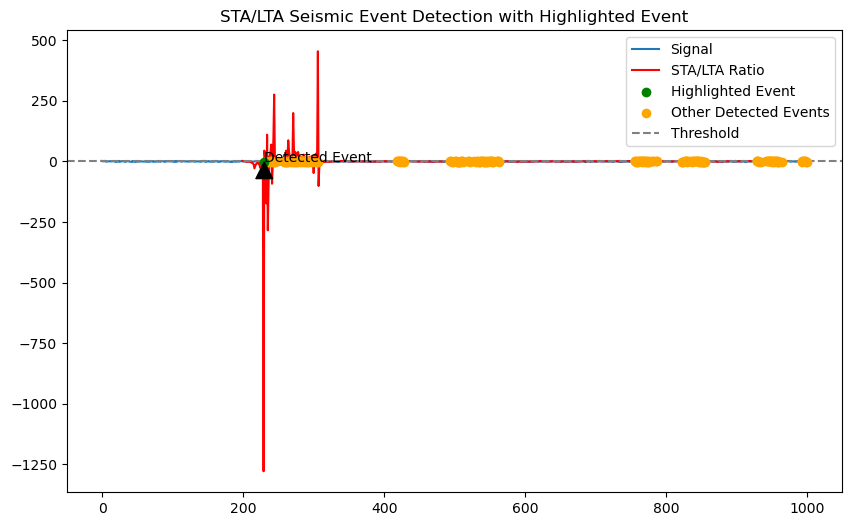

In [7]:
# Generate a random time series
np.random.seed(0)
time_series = np.random.randn(1000)

# Define STA/LTA function
def sta_lta(signal, short_window, long_window, threshold):
    sta = np.convolve(signal, np.ones(short_window), 'valid') / short_window
    lta = np.convolve(signal, np.ones(long_window), 'valid') / long_window
    # Ensure sta and lta are the same length
    sta = sta[:len(lta)]
    ratio = sta / lta

    # Detect when STA/LTA ratio exceeds the threshold
    events = np.where(ratio > threshold)[0] + long_window - 1
    # Adjust events to be within the valid index range of time_series
    events = events[events < len(signal)]
    return events, ratio

# Parameters
short_window = 50
long_window = 200
threshold = 2.0

# Apply STA/LTA algorithm
events, ratio = sta_lta(time_series, short_window, long_window, threshold)


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time_series, label='Signal')

# Correct the x-axis range for the ratio plot
x_range = np.arange(long_window - 1, len(time_series) - short_window + 1)
plt.plot(x_range, ratio[:len(x_range)], label='STA/LTA Ratio', color='r')

# Highlight one detected event
if events.size > 0:
    selected_event = events[0]
    plt.scatter(selected_event, time_series[selected_event], c='g', label='Highlighted Event', zorder=5)
    plt.annotate('Detected Event', xy=(selected_event, time_series[selected_event]), xytext=(selected_event, time_series[selected_event]+1),
                 arrowprops=dict(facecolor='black', shrink=0.05), zorder=5)

plt.scatter(events[1:], time_series[events[1:]], c='orange', label='Other Detected Events', zorder=4)
plt.axhline(threshold, color='grey', linestyle='--', label='Threshold')
plt.legend()
plt.title('STA/LTA Seismic Event Detection with Highlighted Event')
plt.show()

/Users/kaushikpradhan/anaconda3/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (50.0). Applying a high-pass instead.
  warnings.warn(msg)


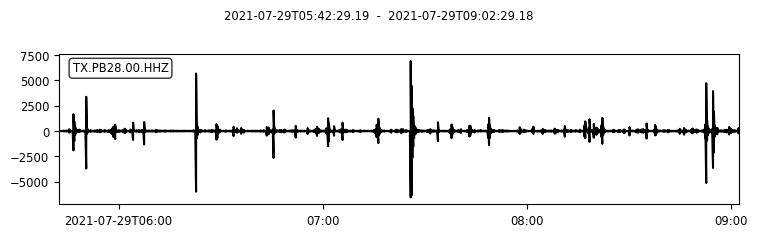

Number of detected seismic events: 195


In [8]:
usgs_6_5_plus = 'https://earthquake.usgs.gov/fdsnws/event/1/query.csv?starttime=2017-01-01%2000:00:00&endtime=2024-02-19%2023:59:59&minmagnitude=6.5&eventtype=earthquake&orderby=time'
data_usgs_6_5_plus = pd.read_csv(usgs_6_5_plus)
big_eq_event = data_usgs_6_5_plus.loc[data_usgs_6_5_plus['mag'].idxmax()] #highest magnitude event
client = Client('IRIS')
event_time = UTCDateTime(big_eq_event['time'])
start_time = event_time - 2000
end_time = event_time + 10000
st = client.get_waveforms('TX', 'PB28', '*', 'HHZ', start_time, end_time)
st.detrend('constant')  # remove mean from the signal

st.filter('bandpass', freqmin=5.0, freqmax=50.0)

st.plot()

waveform = st

# Apply a bandpass filter to the waveform
waveform.detrend(type="demean")
waveform.filter("bandpass", freqmin=1.0, freqmax=20.0)

# Extract the data for processing
tr = waveform[0]
sampling_rate = tr.stats.sampling_rate

# Define STA/LTA parameters
sta = 1  # Short time average window in seconds
lta = 10  # Long time average window in seconds

# Calculate the characteristic function (STA/LTA ratio)
cft = recursive_sta_lta(tr.data, int(sta * sampling_rate), int(lta * sampling_rate))

# Define thresholds for event detection
thr_on = 3.5  # Threshold for event onset
thr_off = 1.0  # Threshold for event end

# Detect events
on_off = trigger_onset(cft, thr_on, thr_off)

# Count the number of detected events
num_events = len(on_off)
print(f"Number of detected seismic events: {num_events}")



/Users/kaushikpradhan/anaconda3/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (20.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


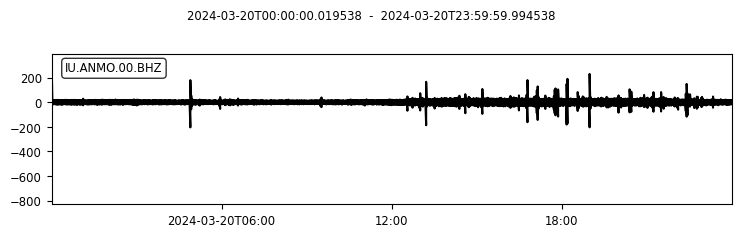

Number of detected seismic events: 44


In [9]:
# Initialize client for IRIS
client = Client("IRIS")

# Define parameters for the data request
network = "IU"  # Network code
station = "ANMO"  # Station code
location = "00"  # Location code
channel = "BHZ"  # Channel code
starttime = UTCDateTime("2024-03-20T00:00:00")  # Start time
endtime = UTCDateTime("2024-03-21T00:00:00")  # End time

# Fetch waveform from the specified station
waveform = client.get_waveforms(network, station, location, channel, starttime, endtime)
# Apply a bandpass filter to the waveform
waveform.detrend(type="demean")
waveform.filter("bandpass", freqmin=1.0, freqmax=20.0)
waveform.plot()

# Extract the data for processing
tr = waveform[0]
sampling_rate = tr.stats.sampling_rate

# Define STA/LTA parameters
sta = 1  # Short time average window in seconds
lta = 10  # Long time average window in seconds

# Calculate the characteristic function (STA/LTA ratio)
cft = recursive_sta_lta(tr.data, int(sta * sampling_rate), int(lta * sampling_rate))

# Define thresholds for event detection
thr_on = 3.5  # Threshold for event onset
thr_off = 1.0  # Threshold for event end

# Detect events
on_off = trigger_onset(cft, thr_on, thr_off)

# Count the number of detected events
num_events = len(on_off)
print(f"Number of detected seismic events: {num_events}")